In [1]:
from bs4 import BeautifulSoup as BS
from urllib.request import urlretrieve, urlopen, Request
import numpy as np
import requests

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900'
r = requests.get(url)
html_doc = r.text
soup = BS(html_doc, 'html.parser')

Found the table class to reference: table class="sortable wikitable

In [3]:
#table class="sortable wikitable
for table in soup.find_all('table'):
    print (table.get('class'))

['plainlinks', 'metadata', 'ambox', 'ambox-content', 'ambox-multiple_issues', 'compact-ambox']
['plainlinks', 'metadata', 'ambox', 'ambox-content', 'ambox-Refimprove']
['plainlinks', 'metadata', 'ambox', 'ambox-style', 'ambox-Cleanup']
['plainlinks', 'metadata', 'ambox', 'ambox-content', 'ambox-Update']
['plainlinks', 'metadata', 'ambox', 'ambox-content']
['sortable', 'wikitable']


In [4]:
import pandas as pd 
quakes = pd.read_html(str(table),header=0)[0]
quakes.columns.values[1]= 'Country'
quakes

,Origin (UTC),Country,Lat,Long,Depth (km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths,Other Source Deaths
0,1900-05-11 17:23,Japan,38.700,141.100,5,7.0 MJMA,NaN,NaN,NaN,NaN,NaN,NaN
1,1900-07-12 06:25,Turkey,40.300,43.100,NaN,5.9 Muk,NaN,NaN,NaN,140.0,NaN,NaN
2,1900-10-29 09:11,Venezuela,11.000,-66.000,0,7.7 Mw,NaN,NaN,NaN,NaN,NaN,NaN
3,1901-02-15 00:00,China,26.000,100.100,0,6.5 Ms,NaN,NaN,NaN,NaN,NaN,NaN
4,1901-03-31 07:11,Bulgaria,43.400,28.700,NaN,6.4 Muk,NaN,NaN,NaN,4.0,NaN,NaN
5,1901-08-09 09:23,Japan,40.500,142.500,35,7.2 Mw,T,NaN,NaN,NaN,NaN,NaN
6,1901-11-15 20:15,New Zealand (see 1901 Cheviot earthquake),-43.000,173.000,0,6.8 Ms,NaN,NaN,NaN,1.0,NaN,NaN
7,1902-01-30 14:01,Japan,40.500,141.300,35,6.9 Ms,NaN,NaN,NaN,1.0,NaN,NaN
8,1902-02-13 09:39,Azerbaijan,40.700,48.600,15,6.9 Muk,NaN,NaN,NaN,86.0,NaN,NaN
9,1902-03-09 07:46,Turkey,40.700,33.600,NaN,5.5 Muk,NaN,NaN,NaN,4.0,NaN,NaN


### strip characters
> alpha characters from Magnitude

> question marks from Lat, Long, Depth

> footnotes from Other Source and EM-DAT Deaths

In [5]:
pattern = r'\(.*\)|\[.*\]|\D'
quakes['Other Source Deaths'] = quakes['Other Source Deaths'].str.replace(pattern,"")
quakes['EM-DAT Total Deaths'] = quakes['EM-DAT Total Deaths'].str.replace(pattern,"")

mag_pattern = r'[^\.\d].*'
quakes['Magnitude'] = quakes['Magnitude'].str.replace(mag_pattern, "")

quakes['Other Source Deaths'] = pd.to_numeric(quakes['Other Source Deaths'])
quakes['EM-DAT Total Deaths'] = pd.to_numeric(quakes['EM-DAT Total Deaths'])
quakes['Magnitude'] = pd.to_numeric(quakes['Magnitude'])

In [6]:
lat_pattern = r'\?'
quakes['Lat'] = quakes['Lat'].replace(lat_pattern, np.nan, regex=True)
quakes['Long'] = quakes['Long'].replace(lat_pattern, np.nan, regex=True)
quakes['Depth (km)'] = quakes['Depth (km)'].replace(lat_pattern, np.nan, regex=True)
quakes['Lat'] = pd.to_numeric(quakes['Lat'])
quakes['Long'] = pd.to_numeric(quakes['Long'])
quakes['Depth (km)'] = pd.to_numeric(quakes['Depth (km)'])

In [7]:
quakes['Deaths'] = quakes[['PDE Total Deaths', 'Utsu Total Deaths', 'EM-DAT Total Deaths', 'Other Source Deaths']].max(axis=1)

In [8]:
#quakes['Country']
country_pattern = r'(, ?| ?\().*'
quakes['Country'] = quakes['Country'].str.replace(country_pattern, "")

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
%matplotlib inline
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [10]:
# once cleaned Lat Long columns, ref http://jonathansoma.com/lede/foundations-2017/classes/geopandas/mapping-with-geopandas/
def make_point(row):
    return Point(row.Long, row.Lat)

points = quakes.apply(make_point, axis=1)
quakes = gpd.GeoDataFrame(quakes, geometry=points)

quakes.crs = {'init': 'epsg:4326'}

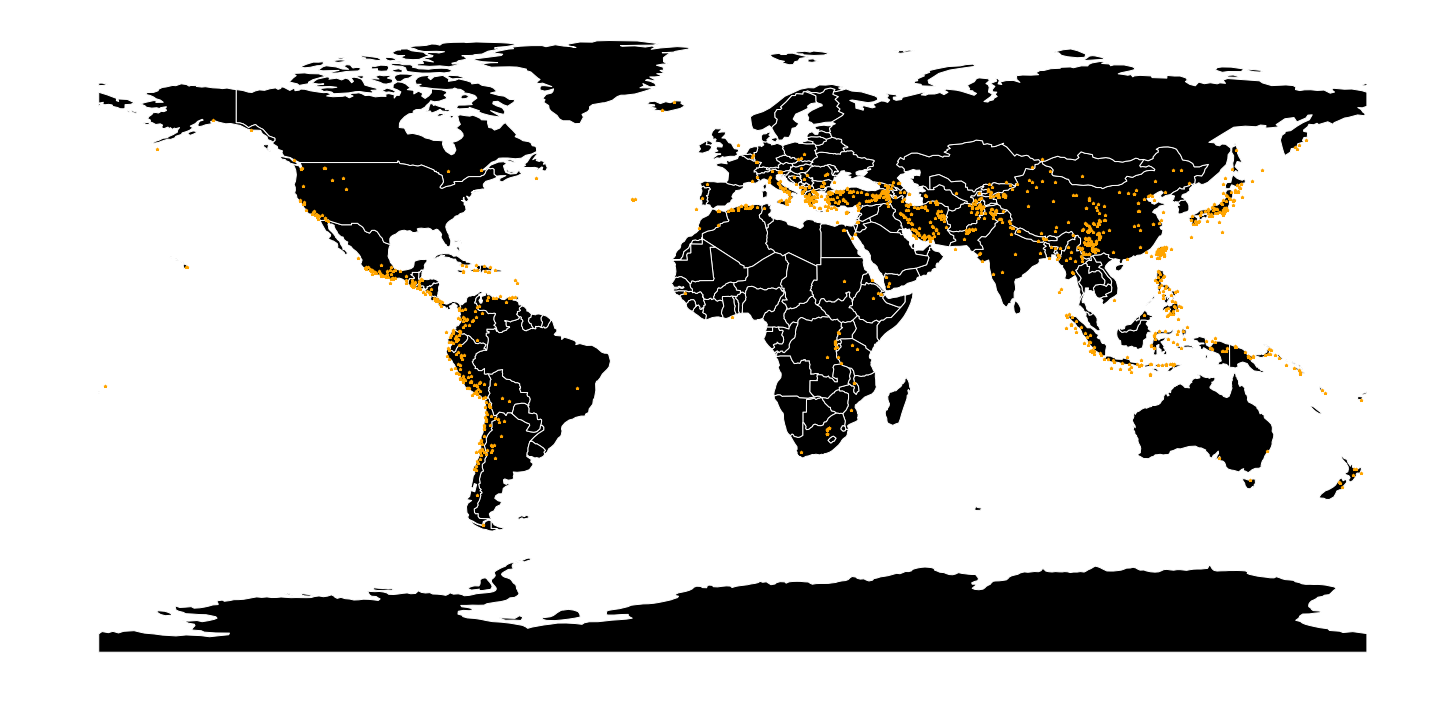

In [11]:
ax = world.plot(color='black', edgecolor='white', figsize=(25,55))
ax.axis('off')
quakes.plot(ax=ax, marker='*', color='orange', markersize=8);

# The break ----- above = confirmed ----- below = testing

In [12]:
'''import ipywidgets as widgets

from IPython.display import display
m = widgets.FloatRangeSlider()
m.value = quakes['Magnitude'].max()

display(m)'''

"import ipywidgets as widgets\n\nfrom IPython.display import display\nm = widgets.FloatRangeSlider()\nm.value = quakes['Magnitude'].max()\n\ndisplay(m)"

In [43]:
from IPython import display
from ipywidgets import widgets
from IPython.display import display, clear_output


m = widgets.FloatRangeSlider(
    value=(0, 15),
    min=quakes['Magnitude'].min(),
    max=quakes['Magnitude'].max(),
    description='Magnitude',
    continuous_update=True,
)

display(m)

A Jupyter Widget

A Jupyter Widget

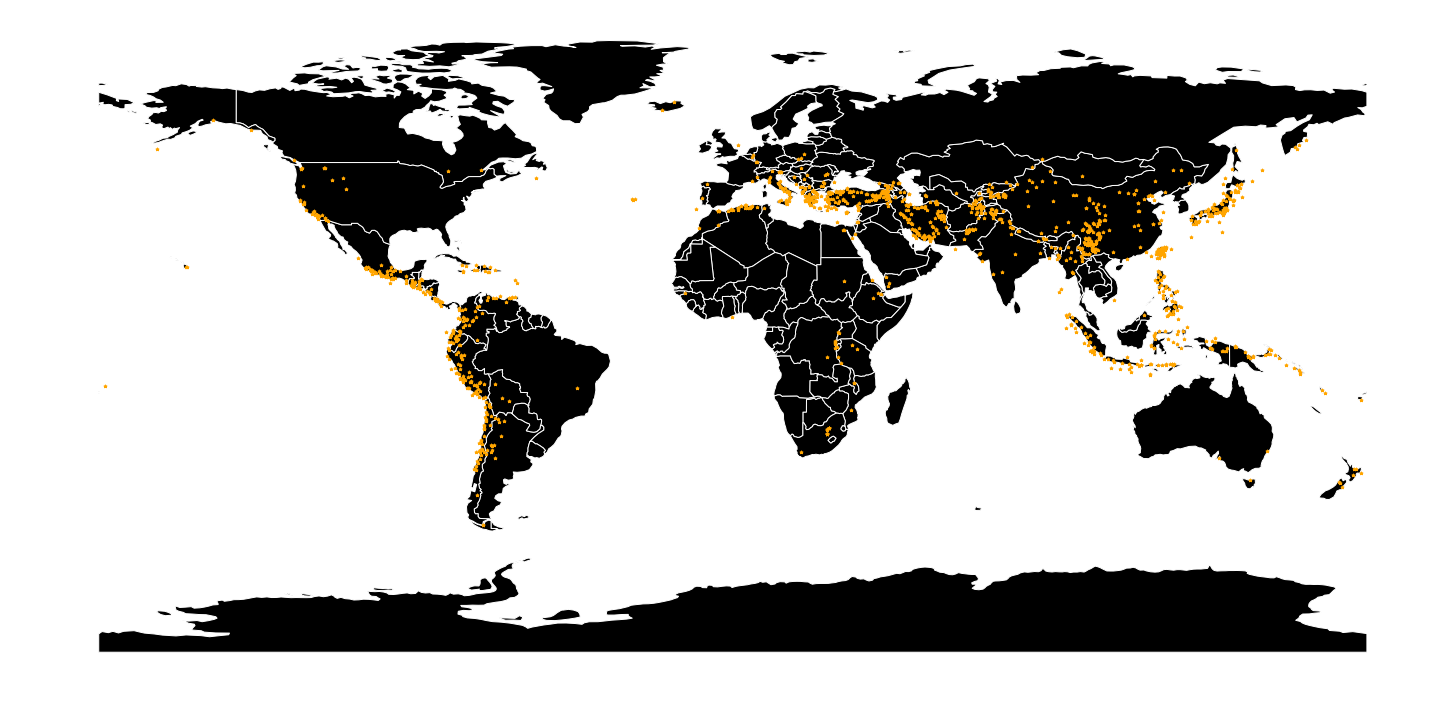

In [49]:
m = widgets.FloatRangeSlider(
    value=(0, 15),
    min=quakes['Magnitude'].min(),
    max=quakes['Magnitude'].max(),
    description='Magnitude',
    continuous_update=False,
)
display(m)

def response(change):
    clear_output(wait=True)
    display(m)
    maximum = change['new'][1]
    minimum = change['new'][0]

    ax = world.plot(color='black', edgecolor='white', figsize=(25,55))
    ax.axis('off')
    quakes.plot(ax=ax, marker='*', color='orange', markersize=10);
        
m.observe(response, names='value')

In [50]:
'''ax = world.plot(color='black', edgecolor='white', figsize=(25,55))
ax.axis('off')
quakes.plot(ax=ax, marker='*', color='orange', markersize=8);'''

"ax = world.plot(color='black', edgecolor='white', figsize=(25,55))\nax.axis('off')\nquakes.plot(ax=ax, marker='*', color='orange', markersize=8);"

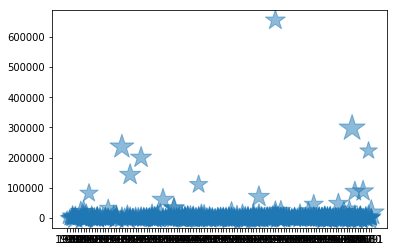

In [15]:
quakes['year'] = quakes['Origin (UTC)'].str[:4]
death_mag_by_year = quakes.groupby(['year','Magnitude'])['Deaths'].sum()
death_mag_by_year=death_mag_by_year.reset_index()
death_mag_by_year

plt.scatter(death_mag_by_year['year'], death_mag_by_year['Deaths'], marker='*', alpha=0.5, s=death_mag_by_year['Magnitude']**3)


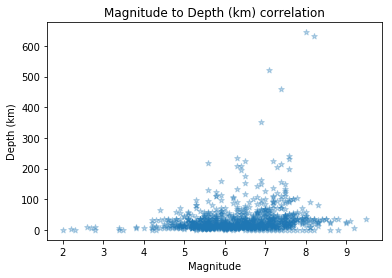

In [16]:
mag_dep = quakes.groupby(['Magnitude','Depth (km)'])['Deaths'].sum()
mag_dep=mag_dep.reset_index()
mag_dep
plt.title('Magnitude to Depth (km) correlation')
plt.xlabel('Magnitude')
plt.ylabel('Depth (km)')
plt.scatter(mag_dep['Magnitude'],mag_dep['Depth (km)'], marker='*', alpha=0.3)#, s=mag_dep['Deaths'])


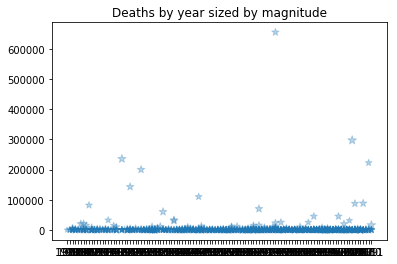

In [17]:
plt.title('Deaths by year sized by magnitude')
plt.scatter(quakes['year'], quakes['Deaths'], marker='*', alpha=0.3, s=quakes['Magnitude']**2)

In [18]:
quake_by_country = quakes.groupby(['Country','year','Magnitude','Deaths'])['Country'].count()

In [19]:
quake_by_country

Country                               year  Magnitude  Deaths
                                      1997  6.9        81.0      1
Afghanistan                           1956  7.6        350.0     1
                                      1972  6.1        11.0      1
                                      1976  5.6        50.0      1
                                      1978  6.1        1.0       1
                                      1981  5.6        1.0       1
                                      1982  6.4        500.0     1
                                      1983  7.4        26.0      1
                                      1984  6.1        1.0       1
                                            6.4        4.0       1
                                      1985  7.4        5.0       1
                                      1990  5.8        11.0      1
                                            6.3        43.0      1
                                      1991  6.8        703.0     1


In [20]:
quakes

,Origin (UTC),Country,Lat,Long,Depth (km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths,Other Source Deaths,Deaths,geometry,year
0,1900-05-11 17:23,Japan,38.7000,141.1000,5.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (141.1 38.7),1900
1,1900-07-12 06:25,Turkey,40.3000,43.1000,NaN,5.9,NaN,NaN,NaN,140.0,NaN,NaN,140.0,POINT (43.1 40.3),1900
2,1900-10-29 09:11,Venezuela,11.0000,-66.0000,0.0,7.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-66 11),1900
3,1901-02-15 00:00,China,26.0000,100.1000,0.0,6.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (100.1 26),1901
4,1901-03-31 07:11,Bulgaria,43.4000,28.7000,NaN,6.4,NaN,NaN,NaN,4.0,NaN,NaN,4.0,POINT (28.7 43.4),1901
5,1901-08-09 09:23,Japan,40.5000,142.5000,35.0,7.2,T,NaN,NaN,NaN,NaN,NaN,NaN,POINT (142.5 40.5),1901
6,1901-11-15 20:15,New Zealand,-43.0000,173.0000,0.0,6.8,NaN,NaN,NaN,1.0,NaN,NaN,1.0,POINT (173 -43),1901
7,1902-01-30 14:01,Japan,40.5000,141.3000,35.0,6.9,NaN,NaN,NaN,1.0,NaN,NaN,1.0,POINT (141.3 40.5),1902
8,1902-02-13 09:39,Azerbaijan,40.7000,48.6000,15.0,6.9,NaN,NaN,NaN,86.0,NaN,NaN,86.0,POINT (48.6 40.7),1902
9,1902-03-09 07:46,Turkey,40.7000,33.6000,NaN,5.5,NaN,NaN,NaN,4.0,NaN,NaN,4.0,POINT (33.6 40.7),1902
